In [15]:
import sys
sys.path.append('..')
from src.evo_eq_model import *

In [16]:

home = os.path.expanduser("~")
project_path =  os.path.relpath("..")
if project_path not in sys.path:
    sys.path.append(project_path)

sys.path.insert(1, project_path)
import analysis.mathematical_functions.funcs as funcs

In [17]:
import random
import numpy.random as rnd
import networkx as nx
from anytree import Node
from tqdm import tqdm
import numpy as np
import os
import sys
# from jupyter_server import serverapp as app; 
# import ipykernel, requests;
if(sys.version_info[1]<= 7):
    import pickle5 as pickle
else:
    import pickle

import pandas as pd
import scipy.interpolate as spi
import scipy.optimize as so

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl

from matplotlib.ticker import FuncFormatter

fmt = lambda x, pos: '{:.1f}'.format(x)
from numba import jit

#matplotlib.use('TkAgg')
from matplotlib.lines import Line2D
plt.rc('mathtext', default='regular')
plt.rc('lines', linewidth=2.0)
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15
plt.rcParams['axes.labelsize']=20
plt.rcParams['legend.fontsize']= 20
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['image.cmap']='coolwarm'
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['figure.titlesize'] = 20
#set legend titlesize to 40
plt.rcParams['legend.title_fontsize'] = 20

In [18]:
def model(X, t, R0, kappa):
    x = X[0]
    y = X[1]
    z = X[2]
    dxdt = - R0/(1+kappa * y) *x * y
    dydt =  R0/(1+kappa* y) * x * y - y
    dzdt = y
    return [dxdt, dydt, dzdt]

def model_w_params(R0, N, k): 
    def model(y,t):
        S = y[0]
        I = y[1]
        R0_eff = R0/(1+k*I/(N))
        dSdt = - R0_eff * S*I/N 
        dIdt =  R0_eff * S*I/N -I
        return [dSdt,dIdt]
    return model

@jit(nopython=True)    
def find_t_intersection(f,g, t):
    #print(np.sign(f - g))
    idx = np.argwhere(np.diff(np.sign(f - g))).flatten()
    #print(idx)
    if len(idx)>0:
        return t[idx[0]]
    else:
        return np.inf

@jit(nopython=True)    
def find_ind_intersection(f,g):
    #print(np.sign(f - g))
    idx = np.argwhere(np.diff(np.sign(f - g))).flatten()
    #print(idx)
    if len(idx)>0:
        return idx[0]
    else:
        return np.inf

@jit(nopython=True)
def get_p_surv_inv_int(fit, dt,reg= 1e-1):
    L = len(fit)
    pi_ext_ode_hand_inv_t = np.zeros(L)
    pi_ext_ode_hand_inv_t[-1] = np.minimum(1/(1+fit[-1]),1-reg)
    for i in range(L-1):
        pi_ext= pi_ext_ode_hand_inv_t[L-1-i]
        pi_ext_ode_hand_inv_t[L-2-i] = pi_ext -dt * (1-pi_ext)*(-1+pi_ext*(1+fit[L-2-i]))
    p_surv = 1-pi_ext_ode_hand_inv_t
    return p_surv

def find_x_inf(R0,k):
    if k>0:
        c = (R0-k+R0*k)/(k*(R0-k))
        rho = 1/(R0/k)
        y_x = lambda x: c*x**rho + x/(rho-1) - 1/k

        roots = so.fsolve(y_x, 0)
        return roots[0]
    else:
        return np.real(-1/R0*sps.lambertw(-R0*np.exp(-R0)))
    
def integrate_trajectory(R0,kappa,N, I0=10):
    S0 = N-I0
    y0 = [S0,I0]
    x_inf = find_x_inf(R0,kappa)
    
    t_end = 1.5*np.log(N)* (1/(R0-1) + 1/(1-R0*x_inf))
    ts = np.linspace(0, t_end,100000)
    dt = ts[1]-ts[0]
    solution  = odeint(model_w_params(R0,N,kappa),y0,ts).T
    x,y= solution
    tp = ts[np.argmax(y)]


    return ts, solution

In [19]:
home = os.path.expanduser("~")
project_path =  os.path.relpath("..")
if project_path not in sys.path:
    sys.path.append(project_path)

sys.path.insert(1, project_path)
output_folder= project_path+'/outputs/'

In [20]:
c_d = lambda d,xi: np.exp(-d/xi)
rho_d = lambda d,dbar: 1/dbar*(1-1/dbar)**(d-1)

In [21]:
from matplotlib.ticker import ScalarFormatter

y_formatter = ScalarFormatter(useOffset=False)


In [22]:
def exp_notation_string(x):
    ex = np.floor(np.log10(x))
    base = x/10**ex
    if ex!=0:
        return fr'${base:.1f}\times 10^{{{int(ex)}}}$'
    else:
        return fr'${base:.1f}$'

print(exp_notation_string(5.6e-3))

$5.6\times 10^{-3}$


In [81]:
R0 = 2.5
N=1e10
dbar = 10
xi = 50
delta= dbar/xi
deltacorr = delta/(1+delta)
U = 1e-6
ds = np.arange(1,10*dbar)
rhos = rho_d(ds,dbar).reshape(-1,1)
plot_adiabatic = False

colors_d= funcs.color_dict(ds,plt.cm.jet)

fit_func = lambda x,y,z, c, R0, kappa: R0/(1+kappa*y) * (x + (1-c)*z) -1 
savefig = 1

dbinsize= 6

compute_kappa_small = 1
if compute_kappa_small:
    kappa_small = 1
    ts_small, sol_small = integrate_trajectory(R0,kappa_small,N)
    S_small, I_small = sol_small
    xs_small, ys_small = S_small/N, I_small/N
    zs_small = 1-xs_small-ys_small
    zinf_small = 1-funcs.x_inf(R0,kappa_small)
    dmin_small = xi*np.log(R0/(R0-1)*zinf_small)
    tp_small = ts_small[np.argmax(ys_small)]

    fit_d_t_small = np.array( [fit_func(xs_small,ys_small,zs_small,c_d(d,xi), R0, kappa_small) for d in ds])

compute_kappa_big = 1
if compute_kappa_big:
    kappa_big= 1e4
    ts_big, sol_big = integrate_trajectory(R0,kappa_big,N)
    S_big, I_big = sol_big
    xs_big, ys_big = S_big/N, I_big/N
    zs_big = 1-xs_big-ys_big
    zinf_big = 1-funcs.x_inf(R0,kappa_big)
    dmin_big = xi*np.log(R0/(R0-1)*zinf_big)

    fit_d_t_big = np.array( [fit_func(xs_big,ys_big,zs_big,c_d(d,xi), R0, kappa_big) for d in ds])



/var/folders/r0/2r01pw2j68bcxs_rw3gqyh880000gn/T/ipykernel_13174/2373276694.py:4: RuntimeWarning: divide by zero encountered in log
  tau_d_t_approx_small = np.log(N*ys_small*s_d_t_small)/(s_d_t_small)
/var/folders/r0/2r01pw2j68bcxs_rw3gqyh880000gn/T/ipykernel_13174/2373276694.py:5: RuntimeWarning: divide by zero encountered in log
  tau_d_t_approx_big = np.log(N*ys_big*s_d_t_big)/(s_d_t_big)
/var/folders/r0/2r01pw2j68bcxs_rw3gqyh880000gn/T/ipykernel_13174/2373276694.py:8: RuntimeWarning: divide by zero encountered in log
  tau_d_t_quad_big = np.sqrt(ts_big**2 + 2*kappa_big/((R0-1)*(1-c_d(ds,xi).reshape(-1,1))) *np.log(N*((R0-1)/kappa_big)**2*(1-c_d(ds,xi).reshape(-1,1))*ts_big))-ts_big
/var/folders/r0/2r01pw2j68bcxs_rw3gqyh880000gn/T/ipykernel_13174/2373276694.py:8: RuntimeWarning: invalid value encountered in sqrt
  tau_d_t_quad_big = np.sqrt(ts_big**2 + 2*kappa_big/((R0-1)*(1-c_d(ds,xi).reshape(-1,1))) *np.log(N*((R0-1)/kappa_big)**2*(1-c_d(ds,xi).reshape(-1,1))*ts_big))-ts_big


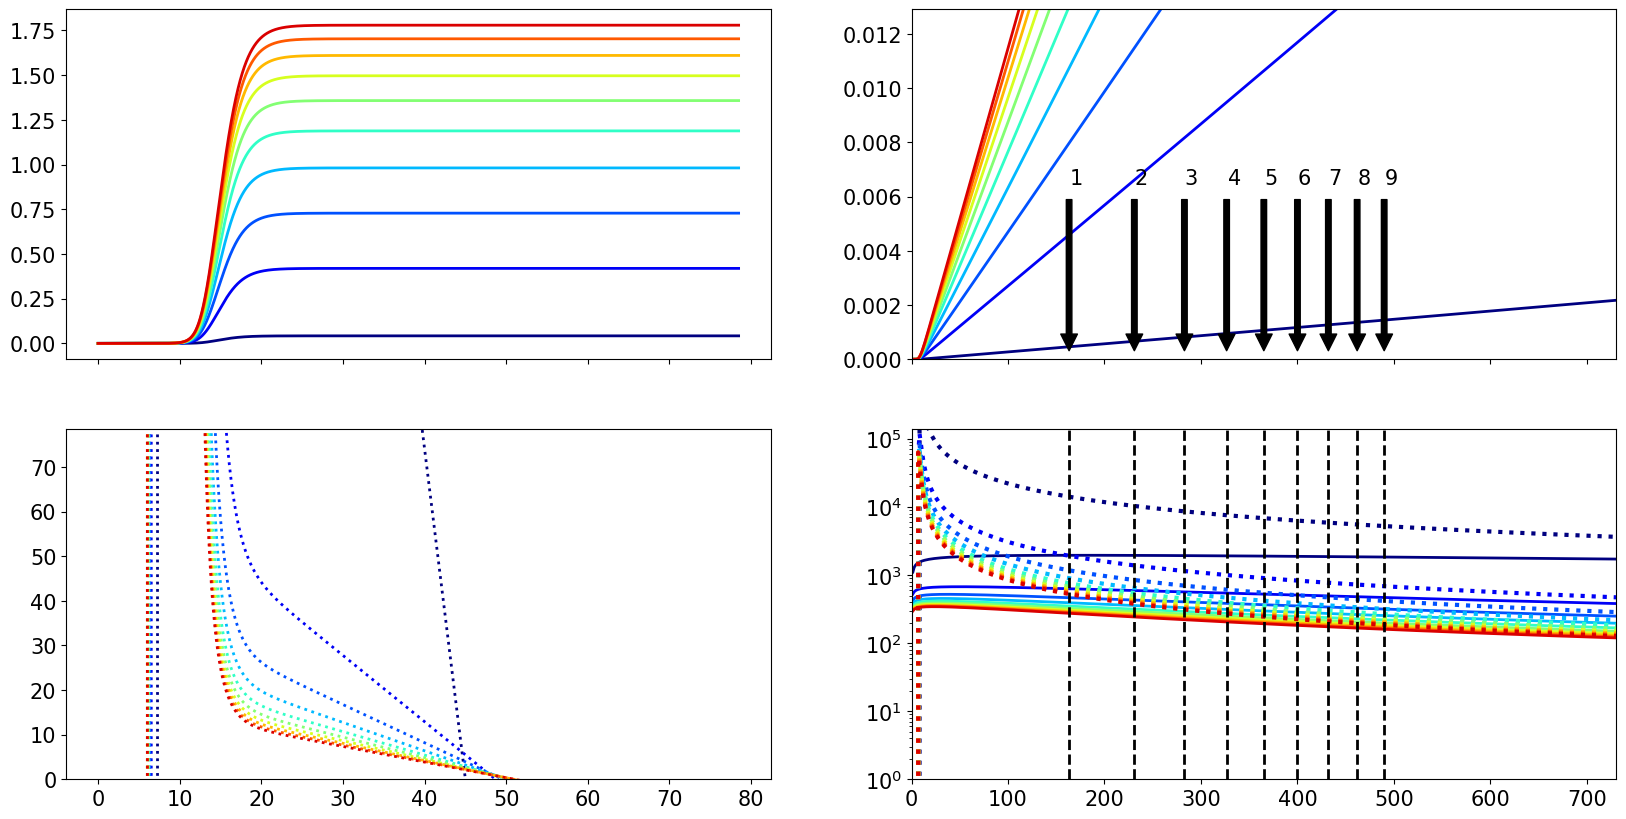

In [84]:
s_d_t_small = fit_d_t_small - (R0/(1+kappa_small*ys_small)*xs_small -1)
s_d_t_big = fit_d_t_big - (R0/(1+kappa_big*ys_big)*xs_big -1)

tau_d_t_approx_small = np.log(N*ys_small*s_d_t_small)/(s_d_t_small)
tau_d_t_approx_big = np.log(N*ys_big*s_d_t_big)/(s_d_t_big)

# tau_d_t_quad_small = 
tau_d_t_quad_big = np.sqrt(ts_big**2 + 2*kappa_big/((R0-1)*(1-c_d(ds,xi).reshape(-1,1))) *np.log(N*((R0-1)/kappa_big)**2*(1-c_d(ds,xi).reshape(-1,1))*ts_big))-ts_big

fig, ax = plt.subplots(2,2,figsize=(20,10),sharex='col')
for d in ds[::10]:
    ax[0,0].plot(ts_small, s_d_t_small[d-1], label = f'd={d}', color = colors_d[d])
    ax[0,1].plot(ts_big, s_d_t_big[d-1], label = f'd={d}', color = colors_d[d])

    ax[1,0].plot(ts_small, tau_d_t_approx_small[d-1], label = f'd={d}', color = colors_d[d],ls=':')
    ax[1,1].plot(ts_big, tau_d_t_approx_big[d-1], label = f'd={d}', color = colors_d[d],ls=':',lw=3)
    ax[1,1].plot(ts_big, tau_d_t_quad_big[d-1], label = f'd={d}', color = colors_d[d],ls='-')

for i in range(1,10):
    # ax[0,1].axvline(kappa_big/(R0-1)*np.sqrt(i/(U*N*deltacorr)), color='k',ls='--')
    ax[1,1].axvline(kappa_big/(R0-1)*np.sqrt(i/(U*N*deltacorr)), color='k',ls='--')

    ax[0,1].annotate(fr'${i}$', xy=(kappa_big/(R0-1)*np.sqrt(i/(U*N*deltacorr)), 0), xytext=(kappa_big/(R0-1)*np.sqrt(i/(U*N*deltacorr)),  np.sqrt(10*deltacorr/(U*N))/2),arrowprops=dict(facecolor='black', shrink=0.05),fontsize=15)

ax[0,1].set_xlim(0,kappa_big/(R0-1) * np.sqrt(20/(U*N*deltacorr)))
ax[0,1].set_ylim(0, np.sqrt(10*deltacorr/(U*N)))

ax[1,0].set_ylim(0, ts_small[-1])
ax[1,1].set_ylim(1, ts_big[-1])

ax[1,1].set_yscale('log')
